In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import seaborn as sn

In [3]:
data = pd.read_csv("data/savant_data.csv")
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FF,2024-04-14,102.9,-2.14,6.18,"Gallo, Joey",608336,695243,strikeout,foul_tip,...,7,6,7,6,7,Strategic,Standard,215.0,0.052,-0.158
1,FF,2024-04-11,102.9,-2.14,6.19,"Seager, Corey",608369,695243,strikeout,swinging_strike,...,1,1,0,0,1,Infield shade,Standard,214.0,-0.064,-0.125
2,FF,2024-04-09,102.0,-2.08,5.71,"Florial, Estevan",664314,656629,strikeout,swinging_strike,...,7,7,5,5,7,Standard,Standard,208.0,-0.016,-0.054
3,FF,2024-04-02,101.8,-2.19,6.26,"Abreu, Wilyer",677800,695243,strikeout,swinging_strike,...,4,4,4,4,4,Standard,Standard,213.0,0.091,-0.457
4,FF,2024-04-06,101.6,-2.03,6.14,"Báez, Javier",595879,695243,strikeout,called_strike,...,4,4,0,0,4,Standard,Standard,210.0,-0.014,-0.309


In [4]:
data.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [9]:
filt_data = data[['player_name', 'events', 'launch_speed', 'launch_angle', 'delta_run_exp']]
filt_data.head(10)

,player_name,events,launch_speed,launch_angle,delta_run_exp
0,"Gallo, Joey",strikeout,NaN,NaN,-0.158
1,"Seager, Corey",strikeout,NaN,NaN,-0.125
2,"Florial, Estevan",strikeout,NaN,NaN,-0.054
3,"Abreu, Wilyer",strikeout,NaN,NaN,-0.457
4,"Báez, Javier",strikeout,NaN,NaN,-0.309
5,"Valdez, Enmanuel",field_out,94.7,28.0,-0.212
6,"Hays, Austin",strikeout,NaN,NaN,-0.110
7,"Mullins, Cedric",field_out,83.1,35.0,-0.200
8,"Kelly, Carson",double,99.5,19.0,0.461
9,"Pérez, Wenceel",strikeout,NaN,NaN,-0.442


In [15]:
filt_data['events'].unique()

array(['strikeout', 'field_out', 'double', 'single', 'walk', 'sac_fly',
       'force_out', 'home_run', 'field_error',
       'grounded_into_double_play', 'hit_by_pitch', 'fielders_choice',
       'triple', 'double_play', 'catcher_interf', 'sac_bunt',
       'strikeout_double_play', 'fielders_choice_out',
       'sac_fly_double_play'], dtype=object)

In [20]:
## Calculating weights for outcomes using run expectancy:

event_group = filt_data.groupby('events').agg(
    avg_run_exp = pd.NamedAgg(column = 'delta_run_exp', aggfunc = 'mean'))
event_group_filt = event_group[event_group.index.isin(['single', 'double', 'triple', 'walk', 'hit_by_pitch', 'home_run'])]

# Rescaling so mean average run expectancy is 1
og_mean = event_group_filt['avg_run_exp'].mean()
event_group_filt['avg_run_rescaled'] = event_group_filt['avg_run_exp']/og_mean
event_group_filt


/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_17955/180231157.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_group_filt['avg_run_rescaled'] = event_group_filt['avg_run_exp']/og_mean


,avg_run_exp,avg_run_rescaled
events,,
double,0.797389,1.107265
hit_by_pitch,0.394553,0.547881
home_run,1.372670,1.906107
single,0.507308,0.704454
triple,1.009682,1.402057
walk,0.239257,0.332236


In [21]:
ev_la_data = filt_data.dropna()
ev_la_data.head()

,player_name,events,launch_speed,launch_angle,delta_run_exp
5,"Valdez, Enmanuel",field_out,94.7,28.0,-0.212
7,"Mullins, Cedric",field_out,83.1,35.0,-0.200
8,"Kelly, Carson",double,99.5,19.0,0.461
10,"Fry, David",single,69.1,22.0,1.122
11,"Story, Trevor",double,93.7,19.0,0.231


Text(0, 0.5, 'Run Expectancy Change')

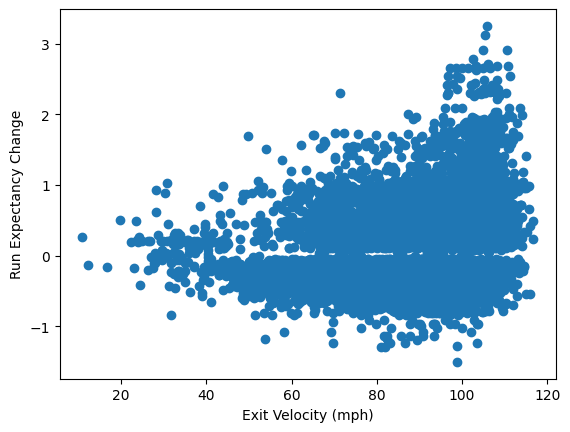

In [24]:
# Visualizing relationship between EV and run exp:
plt.scatter(ev_la_data['launch_speed'], ev_la_data['delta_run_exp'])
plt.xlabel("Exit Velocity (mph)")
plt.ylabel("Run Expectancy Change")

Text(0, 0.5, 'Run Expectancy Change')

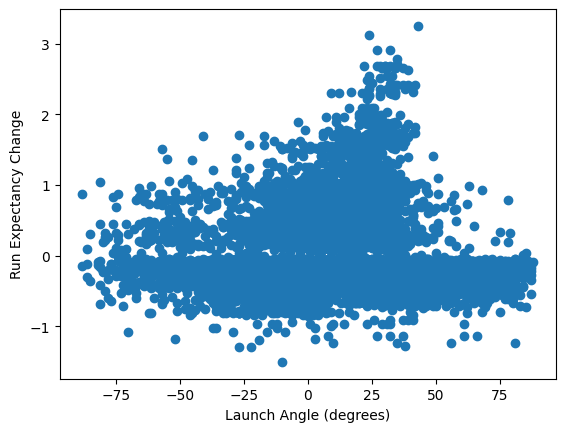

In [25]:
plt.scatter(ev_la_data['launch_angle'], ev_la_data['delta_run_exp'])
plt.xlabel("Launch Angle (degrees)")
plt.ylabel("Run Expectancy Change")

In [27]:
# Creating a random forest model to create "scores" for a certain launch angle and exit velocity:

# train test split (0.8)
X = ev_la_data[['launch_speed', 'launch_angle']]
y = ev_la_data['delta_run_exp']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)


<AxesSubplot: >

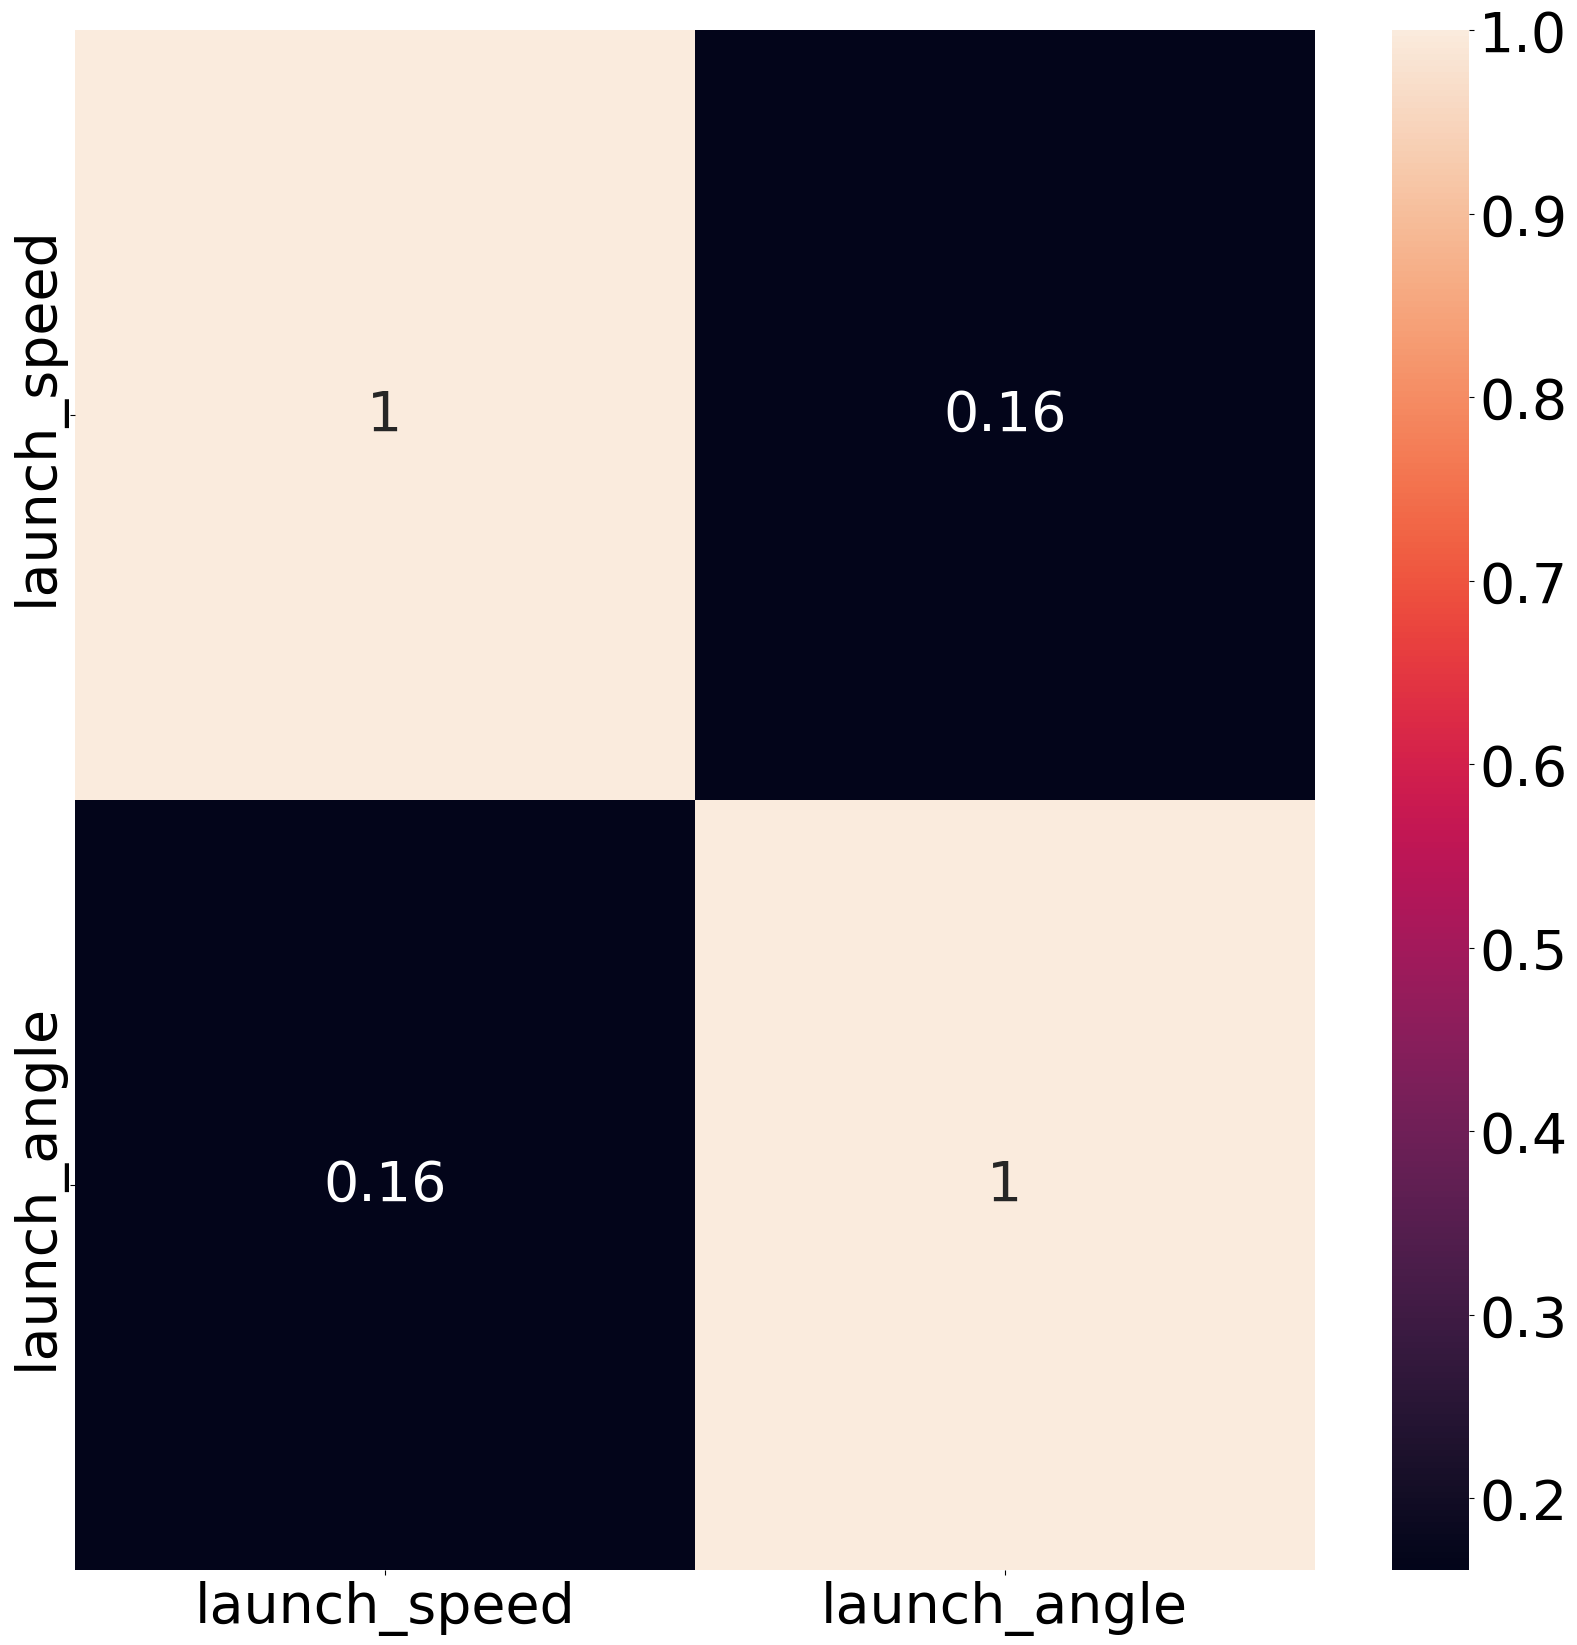

In [33]:
## Analyzing correlations of features
corr_matrix = X_train.corr()
plt.figure(figsize = (20,20))
plt.rcParams.update({'font.size': 40})
sn.heatmap(corr_matrix, annot = True)

# We see fairly limited correlation between EV and LA

array([[<AxesSubplot: title={'center': 'launch_speed'}>,
        <AxesSubplot: title={'center': 'launch_angle'}>]], dtype=object)

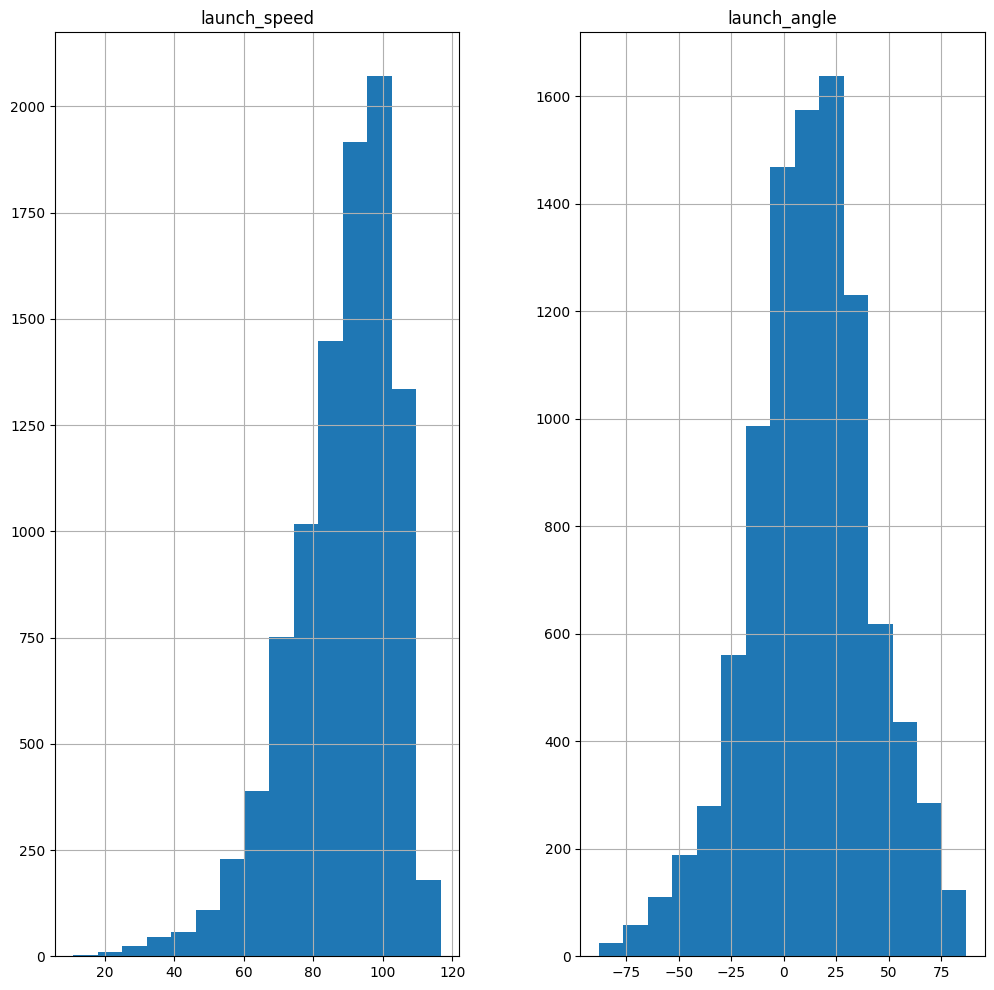

In [46]:
## Examining histograms and distributions of features
plt.rcParams.update({'font.size': 10})
X_train.hist(bins = 15, figsize = (12,12))


# Both are slightly left-tailed, fairly normal though

<AxesSubplot: >

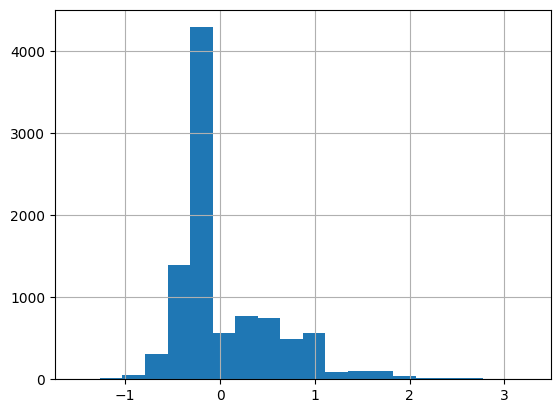

In [45]:
# Looking at distribution of Change in Run Expectancy
y_train.hist(bins = 20)

# We see it is highly centered around -0.2 (which is about average for a normal out)

In [35]:
# Preprocessing:
colnames = list(X_train.columns)
ct = make_column_transformer(
    (StandardScaler(), colnames))

# Fitting X_train with scaled values, transforming both X_train and X_test
transformed_X_train = ct.fit_transform(X_train)
transformed_X_test = ct.transform(X_test)

## Creating transformed data frames
X_train_transformed = pd.DataFrame(transformed_X_train, columns = colnames)
X_test_transformed = pd.DataFrame(transformed_X_test, columns = colnames)
X_train_transformed.head()

,launch_speed,launch_angle
0,0.987215,0.358079
1,-0.699048,-0.268964
2,0.711770,0.079393
3,-0.376576,-0.025114
4,0.187752,0.114229


In [36]:
# Pipeline for random forest model:
pipe_rf = make_pipeline(ct, RandomForestRegressor(random_state = 123, n_jobs = -1))

In [38]:
## Hyperparameter optimization for random forest regressor
param_grid_rf = {"randomforestregressor__max_depth" : [2,4,6,8,10,12,14,16,18,20],
               "randomforestregressor__n_estimators" : [2,4,6,8,10,12,14,16,18,20]}
random_search_rf = RandomizedSearchCV(pipe_rf, param_grid_rf, n_iter = 100, cv = 5, n_jobs = -1,random_state = 123,
                                  scoring = 'neg_root_mean_squared_error')
random_search_rf.fit(X_train, y_train)
results_rf = pd.DataFrame(random_search_rf.cv_results_).set_index("rank_test_score").sort_index()
results_rf.T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
mean_fit_time,0.127012,0.128702,0.126246,0.099827,0.114192,0.100236,0.078092,0.09779,0.310186,0.206071,...,0.264888,0.089948,0.257567,0.308084,0.122903,0.104519,0.08556,0.261652,0.110385,0.179303
std_fit_time,0.030695,0.052654,0.052239,0.044854,0.048212,0.040041,0.040103,0.03385,0.152634,0.079392,...,0.077986,0.064077,0.106144,0.162721,0.075005,0.032694,0.0459,0.154179,0.068875,0.189351
mean_score_time,0.058514,0.013995,0.034309,0.039707,0.040501,0.017648,0.024284,0.025769,0.023362,0.030245,...,0.017432,0.038981,0.058873,0.099171,0.02256,0.069958,0.054971,0.094901,0.048168,0.051349
std_score_time,0.043114,0.007034,0.031142,0.019418,0.045937,0.013265,0.007395,0.017327,0.019371,0.025795,...,0.006841,0.025438,0.071633,0.069055,0.015353,0.061045,0.026189,0.111956,0.033084,0.069388
param_randomforestregressor__n_estimators,20,18,16,12,14,10,8,6,20,18,...,8,2,6,4,4,4,2,2,2,2
param_randomforestregressor__max_depth,6,6,6,6,6,6,6,6,8,8,...,20,12,20,16,18,20,14,16,18,20
params,"{'randomforestregressor__n_estimators': 20, 'r...","{'randomforestregressor__n_estimators': 18, 'r...","{'randomforestregressor__n_estimators': 16, 'r...","{'randomforestregressor__n_estimators': 12, 'r...","{'randomforestregressor__n_estimators': 14, 'r...","{'randomforestregressor__n_estimators': 10, 'r...","{'randomforestregressor__n_estimators': 8, 'ra...","{'randomforestregressor__n_estimators': 6, 'ra...","{'randomforestregressor__n_estimators': 20, 'r...","{'randomforestregressor__n_estimators': 18, 'r...",...,"{'randomforestregressor__n_estimators': 8, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 6, 'ra...","{'randomforestregressor__n_estimators': 4, 'ra...","{'randomforestregressor__n_estimators': 4, 'ra...","{'randomforestregressor__n_estimators': 4, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra..."
split0_test_score,-0.456136,-0.456572,-0.457153,-0.457052,-0.456817,-0.457582,-0.458478,-0.458383,-0.457955,-0.458174,...,-0.512242,-0.528302,-0.516407,-0.522256,-0.526213,-0.528429,-0.551319,-0.56557,-0.574405,-0.579096
split1_test_score,-0.432148,-0.432731,-0.43298,-0.433206,-0.43338,-0.432765,-0.432796,-0.433587,-0.428358,-0.428654,...,-0.491323,-0.499169,-0.493759,-0.500587,-0.510701,-0.513076,-0.533079,-0.550091,-0.559036,-0.562751
split2_test_score,-0.449115,-0.449427,-0.449497,-0.448855,-0.449305,-0.448741,-0.44905,-0.448769,-0.453769,-0.453395,...,-0.516618,-0.516191,-0.518943,-0.51836,-0.52705,-0.531923,-0.539086,-0.549821,-0.558451,-0.564974


In [39]:
## Looking at optimized hyperparameters
results_rf.T.iloc[6][1]

{'randomforestregressor__n_estimators': 20,
 'randomforestregressor__max_depth': 6}

In [40]:
# Creating new pipeline
pipe_rf1 = make_pipeline(ct, RandomForestRegressor(random_state = 123, n_jobs = -1, n_estimators = 20, max_depth = 6))

In [42]:
# Fitting and calculating test score:
pipe_rf1.fit(X_train, y_train)
test_predict = pipe_rf1.predict(X_test)
test_score = mean_squared_error(y_test, pipe_rf1.predict(X_test), squared = False)
test_score

0.45149478323828124

In [49]:
# Predicting on dataset values
ev_la = ev_la_data[['launch_speed', 'launch_angle']]

ev_la_preds = pipe_rf1.predict(ev_la)

# Scaling to ensure all values are > 0 using logistic function if prediction < 0 and exponential transformation
# to ensure all predictions > 0 have value > 1.

def scale_predictions(preds):
    # Scales logistically if pred < 0, exponentially + 1 if pred > 0
    scaled = np.where(preds < 0, 1 / (1 + np.exp(-preds)), np.exp(preds) + 1)
    return scaled
scaled_ev_la_preds = scale_predictions(ev_la_preds)
ev_la_data['run_coef'] = scaled_ev_la_preds
ev_la_data.head()

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_17955/1631697088.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_la_data['run_coef'] = scaled_ev_la_preds


,player_name,events,launch_speed,launch_angle,delta_run_exp,run_coef
5,"Valdez, Enmanuel",field_out,94.7,28.0,-0.212,0.472223
7,"Mullins, Cedric",field_out,83.1,35.0,-0.200,0.466588
8,"Kelly, Carson",double,99.5,19.0,0.461,2.335711
10,"Fry, David",single,69.1,22.0,1.122,2.368320
11,"Story, Trevor",double,93.7,19.0,0.231,2.303315


In [50]:
event_group_filt

,avg_run_exp,avg_run_rescaled
events,,
double,0.797389,1.107265
hit_by_pitch,0.394553,0.547881
home_run,1.372670,1.906107
single,0.507308,0.704454
triple,1.009682,1.402057
walk,0.239257,0.332236


In [57]:
# Calculating plate appearances for each player

pa = filt_data.groupby('player_name').count()
pa_tot = pa[['events']]
pa_tot.head(10)


,events
player_name,
"Abrams, CJ",54
"Abreu, José",50
"Abreu, Wilyer",29
"Acuña Jr., Ronald",65
"Adames, Willy",63
"Adams, Riley",28
"Adell, Jo",21
"Ahmed, Nick",48
"Albies, Ozzie",65


In [61]:
# Combining outcome coefficients with run coefficients as score contribution
def calculate_contribution(row):
    event_type = row['events']
    rc = row['run_coef']
    coefficient = event_group_filt.loc[event_type, 'avg_run_rescaled'] if event_type in event_group_filt.index else 0
    return coefficient * rc

ev_la_data['score_contribution'] = ev_la_data.apply(calculate_contribution, axis=1)
ev_la_success = ev_la_data[ev_la_data['events'].isin(['single', 'double', 'triple', 'walk', 'hit_by_pitch', 'home_run'])]
ev_la_success.head(10)


/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_17955/4385188.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_la_data['score_contribution'] = ev_la_data.apply(calculate_contribution, axis=1)


,player_name,events,launch_speed,launch_angle,delta_run_exp,run_coef,score_contribution
8,"Kelly, Carson",double,99.5,19.0,0.461,2.335711,2.586251
10,"Fry, David",single,69.1,22.0,1.122,2.368320,1.668373
11,"Story, Trevor",double,93.7,19.0,0.231,2.303315,2.550380
15,"McCann, James",single,97.7,-5.0,0.321,0.496488,0.349753
25,"Ramírez, José",single,68.9,-28.0,0.831,0.454928,0.320476
30,"Ruiz, Keibert",single,76.1,51.0,1.102,2.042712,1.438997
31,"Harris II, Michael",single,99.4,-31.0,0.587,0.462612,0.325889
34,"Ruiz, Keibert",single,100.4,12.0,0.270,2.429138,1.711216
36,"Volpe, Anthony",double,100.0,18.0,0.755,2.367674,2.621643
39,"Betts, Mookie",single,98.4,-7.0,1.525,0.469402,0.330672


In [69]:
# Formula for metwOBA:
# (0.33*BB + 0.55*HBP + 0.70*1B*RC + 1.11*2B*RC + 1.40*3B*RC + 1.91*HR*RC)/PA
# Where RC is the previously calculated run coefficient from EV and LA

player_scores = ev_la_success.groupby('player_name')['score_contribution'].sum().reset_index()
final_data = player_scores.merge(pa_tot, on='player_name')

# Calculate final scores
final_data['metwOBA'] = final_data['score_contribution'] / final_data['events']
final_data = final_data.rename(columns = {'events':'PA'})
final_data.sort_values(by = 'metwOBA', ascending = False).head(15)


,player_name,score_contribution,PA,metwOBA
185,"Lewis, Royce",8.595035,2,4.297517
316,"Sosa, Edmundo",10.804291,7,1.543470
79,"Cowser, Colton",47.671220,38,1.254506
169,"Jung, Josh",23.657125,19,1.245112
28,"Bart, Joey",15.522547,13,1.194042
248,"Ozuna, Marcell",73.726289,63,1.170259
77,"Cooper, Garrett",17.121690,15,1.141446
385,"Witt Jr., Bobby",74.029636,72,1.028189
51,"Busch, Michael",56.237436,56,1.004240
388,"Yelich, Christian",43.839707,45,0.974216


In [70]:
final_data.to_csv("data/metwOBAlb.csv")